In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import random
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!wget https://raw.githubusercontent.com/aLotOfGluten/IIC3633-Proyecto/refs/heads/main/data_processing/processed_h1/train_interactions_idx.csv
!wget https://raw.githubusercontent.com/aLotOfGluten/IIC3633-Proyecto/refs/heads/main/data_processing/processed_h1/test_interactions_idx.csv
!wget https://raw.githubusercontent.com/aLotOfGluten/IIC3633-Proyecto/refs/heads/main/data_processing/processed_h1/user_map.csv
!wget https://raw.githubusercontent.com/aLotOfGluten/IIC3633-Proyecto/refs/heads/main/data_processing/processed_h1/item_map.csv
!wget https://raw.githubusercontent.com/aLotOfGluten/IIC3633-Proyecto/refs/heads/main/data_processing/processed_h1/item_labels.csv
!wget https://raw.githubusercontent.com/aLotOfGluten/IIC3633-Proyecto/refs/heads/main/data_processing/processed_h1/item_text_clean.csv

--2025-10-03 19:57:39--  https://raw.githubusercontent.com/aLotOfGluten/IIC3633-Proyecto/refs/heads/main/data_processing/processed_h1/train_interactions_idx.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 680217 (664K) [text/plain]
Saving to: ‘train_interactions_idx.csv.7’

train_interactions_ 100%[===================>] 664.27K  --.-KB/s    in 0.04s   

2025-10-03 19:57:40 (14.4 MB/s) - ‘train_interactions_idx.csv.7’ saved [680217/680217]

--2025-10-03 19:57:40--  https://raw.githubusercontent.com/aLotOfGluten/IIC3633-Proyecto/refs/heads/main/data_processing/processed_h1/test_interactions_idx.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.co

# Implementación Sistemas de Recomendación


In [3]:
train_interactions = pd.read_csv("train_interactions_idx.csv")
test_interactions = pd.read_csv("test_interactions_idx.csv")

user_map = pd.read_csv("user_map.csv")
item_map = pd.read_csv("item_map.csv")
item_labels = pd.read_csv("item_labels.csv")

print(train_interactions.head())
print(test_interactions.head())

   user_idx  item_idx  interaction
0         0      1025            1
1         0       279            1
2         0       215            1
3         0      2021            1
4         0      2001            1
   user_idx  item_idx  interaction
0         0       974            1
1         1      2206            1
2         2       397            1
3         3      1073            1
4         4      1639            1


KNN User-User

In [4]:
n_users = user_map.shape[0]
n_items = item_map.shape[0]

train_matrix = csr_matrix(
    (np.ones(len(train_interactions)),
     (train_interactions["user_idx"], train_interactions["item_idx"])),
    shape=(n_users, n_items)
)

train_matrix.shape

(4856, 2308)

In [5]:
user_similarity = cosine_similarity(train_matrix)

def recommend_uknn(user_id, k_neighbors=20, top_k=10):
    sims = user_similarity[user_id]
    neighbors = np.argsort(sims)[::-1][1:k_neighbors+1]
    neighbor_items = train_matrix[neighbors].sum(axis=0).A1
    user_items = train_matrix[user_id].toarray().flatten()
    neighbor_items[user_items > 0] = -1
    recs = np.argsort(neighbor_items)[::-1][:top_k]
    return recs

In [6]:
test_user = 0
print("UKNN:", recommend_uknn(test_user, top_k=10))

UKNN: [ 974 1971 1836 1036  219  255  921 2151 1184 1024]


Most Popular

In [7]:
valid_items = set(item_labels["item_idx"])
item_popularity = np.array(train_matrix.sum(axis=0)).flatten()
most_popular_ranking = [i for i in np.argsort(item_popularity)[::-1] if i in valid_items]

def recommend_most_popular(user_id, top_k=10):
    user_items = train_matrix[user_id].toarray().flatten()
    recs = [i for i in most_popular_ranking if user_items[i] == 0][:top_k]
    return recs

In [8]:
print("Most Popular:", recommend_most_popular(test_user, top_k=10))

Most Popular: [np.int64(2137), np.int64(2151), np.int64(1956), np.int64(1329), np.int64(2187), np.int64(1142), np.int64(2261), np.int64(1317), np.int64(1044), np.int64(1056)]


Random

In [9]:
all_items = item_labels["item_idx"].tolist()

def recommend_random(user_id, top_k=10):
    user_items = train_matrix[user_id].toarray().flatten()
    available_items = [i for i in all_items if user_items[i] == 0]
    return random.sample(available_items, min(top_k, len(available_items)))

In [10]:
print("Random:", recommend_random(test_user, top_k=10))

Random: [2191, 1524, 1164, 1150, 570, 242, 1603, 257, 1911, 42]


Item KNN

In [11]:
item_similarity = cosine_similarity(train_matrix.T)

def recommend_iknn(user_id, k_neighbors=20, top_k=10):
    user_items = train_matrix[user_id].toarray().flatten()
    consumed_items = np.where(user_items > 0)[0]
    scores = np.zeros(train_matrix.shape[1])
    for item in consumed_items:
        sims = item_similarity[item]
        neighbors = np.argsort(sims)[::-1][1:k_neighbors+1]
        scores[neighbors] += sims[neighbors]
    scores[consumed_items] = -1
    recs = np.argsort(scores)[::-1][:top_k]
    return recs

TF-IDF + Similaridad de Contenido

In [12]:
item_text = pd.read_csv("item_text_clean.csv")

idx_to_tfidf_pos = {row["item_idx"]: i for i, row in item_text.iterrows()}
tfidf_pos_to_idx = {i: row["item_idx"] for i, row in item_text.iterrows()}

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    stop_words='english'
)

tfidf_matrix = vectorizer.fit_transform(item_text["text_clean"].fillna(""))
content_similarity = cosine_similarity(tfidf_matrix)

def recommend_tfidf(user_id, k_neighbors=20, top_k=10):
    user_items = train_matrix[user_id].toarray().flatten()
    consumed_items = np.where(user_items > 0)[0]

    consumed_items_with_text = [item for item in consumed_items if item in idx_to_tfidf_pos]

    if len(consumed_items_with_text) == 0:
        return recommend_random(user_id, top_k)

    scores = np.zeros(train_matrix.shape[1])

    for item_idx in consumed_items_with_text:
        tfidf_pos = idx_to_tfidf_pos[item_idx]
        sims = content_similarity[tfidf_pos]

        neighbor_positions = np.argsort(sims)[::-1][1:k_neighbors+1]

        for neighbor_pos in neighbor_positions:
            neighbor_idx = tfidf_pos_to_idx[neighbor_pos]
            scores[neighbor_idx] += sims[neighbor_pos]

    scores[consumed_items] = -1

    recs = np.argsort(scores)[::-1][:top_k]
    return recs

 # Análisis de Recomendaciones

In [13]:
labels_map = dict(zip(item_labels["item_idx"], item_labels["label"]))
label_classes = sorted(item_labels["label"].unique())

In [14]:
def bias_distribution(recs, base_dist):
    labels = [labels_map[i] for i in recs]
    rec_dist = Counter(labels)
    total = sum(rec_dist.values())
    return {l: rec_dist.get(l,0)/total - base_dist[l] for l in base_dist}

In [15]:
def precision_at_k_by_class(model_func, test_users, K=10):
    prec = {l: [] for l in label_classes}
    for u in test_users:
        recs = model_func(u, top_k=K)
        true_items = test_interactions[test_interactions["user_idx"]==u]["item_idx"].tolist()
        for l in label_classes:
            true_l = [i for i in true_items if labels_map.get(i)==l]
            if len(true_l)>0:
                hit = len(set(recs) & set(true_l)) / K
                prec[l].append(hit)
    return {l: np.mean(prec[l]) if len(prec[l])>0 else 0.0 for l in label_classes}

In [16]:
def exposure(recs_all):
    all_labels = [labels_map[i] for recs in recs_all for i in recs if i in labels_map]
    total = len(all_labels)
    return {l: all_labels.count(l)/total for l in label_classes}

In [17]:
def coverage(recs_all):
    rec_items = set([i for recs in recs_all for i in recs])
    cov = {}
    for l in label_classes:
        items_l = set(item_labels[item_labels["label"]==l]["item_idx"])
        cov[l] = len(rec_items & items_l) / len(items_l)
    return cov

In [18]:
def mrr_at_k(model_func, test_users, K=10):
    mrr_scores = []
    for u in test_users:
        recs = model_func(u, top_k=K)
        true_items = set(test_interactions[test_interactions["user_idx"]==u]["item_idx"])

        for rank, item in enumerate(recs, 1):
            if item in true_items:
                mrr_scores.append(1.0 / rank)
                break
        else:
            mrr_scores.append(0.0)

    return np.mean(mrr_scores)

In [19]:
def inter_list_diversity(recs_all):
    from itertools import combinations

    diversities = []
    for recs1, recs2 in combinations(recs_all, 2):
        set1, set2 = set(recs1), set(recs2)
        diversity = 1 - (len(set1 & set2) / len(set1 | set2))
        diversities.append(diversity)

    return np.mean(diversities)

In [20]:
test_users = test_interactions["user_idx"].unique()
base_distance = item_labels["label"].value_counts(normalize=True).to_dict()

UKNN

In [21]:
recs_all = [recommend_uknn(user, top_k=10) for user in test_users]

print("=" * 60)
print("UKNN - User-based KNN")
print("=" * 60)
print("MRR@10:", f"{mrr_at_k(recommend_uknn, test_users):.4f}")
print("ILD:", f"{inter_list_diversity(recs_all):.4f}")
print("\nBias de labels:", bias_distribution(recs_all[0], base_distance))
print("Precision@10:", precision_at_k_by_class(recommend_uknn, test_users))
print("Exposure por label:", exposure(recs_all))
print("Coverage por label:", coverage(recs_all))

UKNN - User-based KNN
MRR@10: 0.1246
ILD: 0.9870

Bias de labels: {'non-rumor': 0.13553719008264464, 'unverified': 0.04517906336088151, 'true': -0.0460973370064279, 'false': -0.13461891643709825}
Precision@10: {'false': np.float64(0.007861635220125786), 'non-rumor': np.float64(0.025658876181004476), 'true': np.float64(0.011746987951807229), 'unverified': np.float64(0.040831295843520785)}
Exposure por label: {'false': 0.0948556365583426, 'non-rumor': 0.5093702376539396, 'true': 0.10659417603690433, 'unverified': 0.28917994975081346}
Coverage por label: {'false': 0.5538160469667319, 'non-rumor': 0.8767361111111112, 'true': 0.6697761194029851, 'unverified': 0.7315315315315315}


Most Popular

In [22]:
recs_all = [recommend_most_popular(user, top_k=10) for user in test_users]

print("=" * 60)
print("Most Popular")
print("=" * 60)
print("MRR@10:", f"{mrr_at_k(recommend_most_popular, test_users):.4f}")
print("ILD:", f"{inter_list_diversity(recs_all):.4f}")
print("\nBias de labels:", bias_distribution(recs_all[0], base_distance))
print("Precision@10:", precision_at_k_by_class(recommend_most_popular, test_users))
print("Exposure por label:", exposure(recs_all))
print("Coverage por label:", coverage(recs_all))

Most Popular
MRR@10: 0.0070
ILD: 0.1172

Bias de labels: {'non-rumor': 0.23553719008264462, 'unverified': 0.24517906336088152, 'true': -0.2460973370064279, 'false': -0.23461891643709826}
Precision@10: {'false': np.float64(0.0), 'non-rumor': np.float64(0.004027846842366982), 'true': np.float64(0.0), 'unverified': np.float64(0.0074164629176854124)}
Exposure por label: {'false': 0.0, 'non-rumor': 0.5170510708401977, 'true': 0.0, 'unverified': 0.4829489291598023}
Coverage por label: {'false': 0.0, 'non-rumor': 0.017361111111111112, 'true': 0.0, 'unverified': 0.012612612612612612}


Random

In [23]:
recs_all = [recommend_random(user, top_k=10) for user in test_users]

print("=" * 60)
print("Random")
print("=" * 60)
print("MRR@10:", f"{mrr_at_k(recommend_random, test_users):.4f}")
print("ILD:", f"{inter_list_diversity(recs_all):.4f}")
print("\nBias de labels:", bias_distribution(recs_all[0], base_distance))
print("Precision@10:", precision_at_k_by_class(recommend_random, test_users))
print("Exposure por label:", exposure(recs_all))
print("Coverage por label:", coverage(recs_all))

Random
MRR@10: 0.0012
ILD: 0.9976

Bias de labels: {'non-rumor': -0.06446280991735537, 'unverified': 0.04517906336088151, 'true': 0.053902662993572076, 'false': -0.034618916437098246}
Precision@10: {'false': np.float64(0.0006289308176100629), 'non-rumor': np.float64(0.00034808552958727007), 'true': np.float64(0.00030120481927710846), 'unverified': np.float64(0.00032599837000814997)}
Exposure por label: {'false': 0.2360996705107084, 'non-rumor': 0.26418863261943987, 'true': 0.24779654036243823, 'unverified': 0.25191515650741353}
Coverage por label: {'false': 1.0, 'non-rumor': 1.0, 'true': 1.0, 'unverified': 1.0}


IKNN

In [24]:
recs_all = [recommend_iknn(user, top_k=10) for user in test_users]

print("=" * 60)
print("IKNN - Item-based KNN")
print("=" * 60)
print("MRR@10:", f"{mrr_at_k(recommend_iknn, test_users):.4f}")
print("ILD:", f"{inter_list_diversity(recs_all):.4f}")
print("\nBias de labels:", bias_distribution(recs_all[0], base_distance))
print("Precision@10:", precision_at_k_by_class(recommend_iknn, test_users))
print("Exposure por label:", exposure(recs_all))
print("Coverage por label:", coverage(recs_all))

IKNN - Item-based KNN
MRR@10: 0.1792
ILD: 0.9833

Bias de labels: {'non-rumor': 0.6355371900826446, 'unverified': -0.15482093663911847, 'true': -0.2460973370064279, 'false': -0.23461891643709826}
Precision@10: {'false': np.float64(0.007861635220125788), 'non-rumor': np.float64(0.02381899552461462), 'true': np.float64(0.011295180722891566), 'unverified': np.float64(0.06397718011409943)}
Exposure por label: {'false': 0.09838935574229692, 'non-rumor': 0.5357348821881693, 'true': 0.11538144669632559, 'unverified': 0.2504943153732081}
Coverage por label: {'false': 0.8023483365949119, 'non-rumor': 0.8680555555555556, 'true': 0.7947761194029851, 'unverified': 0.836036036036036}


TF-IDF

In [25]:
recs_all = [recommend_tfidf(user, top_k=10) for user in test_users]

print("=" * 60)
print("TF-IDF + Similaridad de Contenido")
print("=" * 60)
print("MRR@10:", f"{mrr_at_k(recommend_tfidf, test_users):.4f}")
print("ILD:", f"{inter_list_diversity(recs_all):.4f}")
print("\nBias de labels:", bias_distribution(recs_all[0], base_distance))
print("Precision@10:", precision_at_k_by_class(recommend_tfidf, test_users))
print("Exposure por label:", exposure(recs_all))
print("Coverage por label:", coverage(recs_all))

TF-IDF + Similaridad de Contenido
MRR@10: 0.0532
ILD: 0.9756

Bias de labels: {'non-rumor': 0.03553719008264461, 'unverified': -0.2548209366391185, 'true': 0.2539026629935721, 'false': -0.034618916437098246}
Precision@10: {'false': np.float64(0.005870020964360586), 'non-rumor': np.float64(0.006166086524117356), 'true': np.float64(0.004216867469879518), 'unverified': np.float64(0.026405867970660146)}
Exposure por label: {'false': 0.16663920922570016, 'non-rumor': 0.31777182866556836, 'true': 0.20364497528830314, 'unverified': 0.31194398682042834}
Coverage por label: {'false': 0.8571428571428571, 'non-rumor': 0.8402777777777778, 'true': 0.9011194029850746, 'unverified': 0.8486486486486486}


Comparación Final

In [26]:
print("=" * 80)
print("RESUMEN COMPARATIVO DE MODELOS")
print("=" * 80)

models = {
    "UKNN": recommend_uknn,
    "IKNN": recommend_iknn,
    "Most Popular": recommend_most_popular,
    "Random": recommend_random,
    "TF-IDF": recommend_tfidf
}

results = []

for name, model_func in models.items():
    recs_all = [model_func(user, top_k=10) for user in test_users]

    mrr = mrr_at_k(model_func, test_users)
    ild = inter_list_diversity(recs_all)
    exp = exposure(recs_all)
    cov = coverage(recs_all)

    results.append({
        "Modelo": name,
        "MRR@10": mrr,
        "ILD": ild,
        "Exp_False": exp['false'],
        "Exp_True": exp['true'],
        "Cov_False": cov['false'],
        "Cov_True": cov['true']
    })

df_results = pd.DataFrame(results)
print("\n", df_results.to_string(index=False))

print("\n" + "=" * 80)
print("ANÁLISIS:")
print("- MRR@10: Mayor es mejor (calidad del ranking)")
print("- ILD: Mayor es mejor (diversidad entre usuarios)")
print("- Exposure: Distribución de visibilidad por clase")
print("- Coverage: Proporción del catálogo recomendado por clase")
print("=" * 80)

RESUMEN COMPARATIVO DE MODELOS

       Modelo   MRR@10      ILD  Exp_False  Exp_True  Cov_False  Cov_True
        UKNN 0.124580 0.987049   0.094856  0.106594   0.553816  0.669776
        IKNN 0.179174 0.983267   0.098389  0.115381   0.802348  0.794776
Most Popular 0.007049 0.117156   0.000000  0.000000   0.000000  0.000000
      Random 0.001164 0.997575   0.230560  0.247014   1.000000  1.000000
      TF-IDF 0.053176 0.975608   0.166639  0.203645   0.857143  0.901119

ANÁLISIS:
- MRR@10: Mayor es mejor (calidad del ranking)
- ILD: Mayor es mejor (diversidad entre usuarios)
- Exposure: Distribución de visibilidad por clase
- Coverage: Proporción del catálogo recomendado por clase


Gráficos

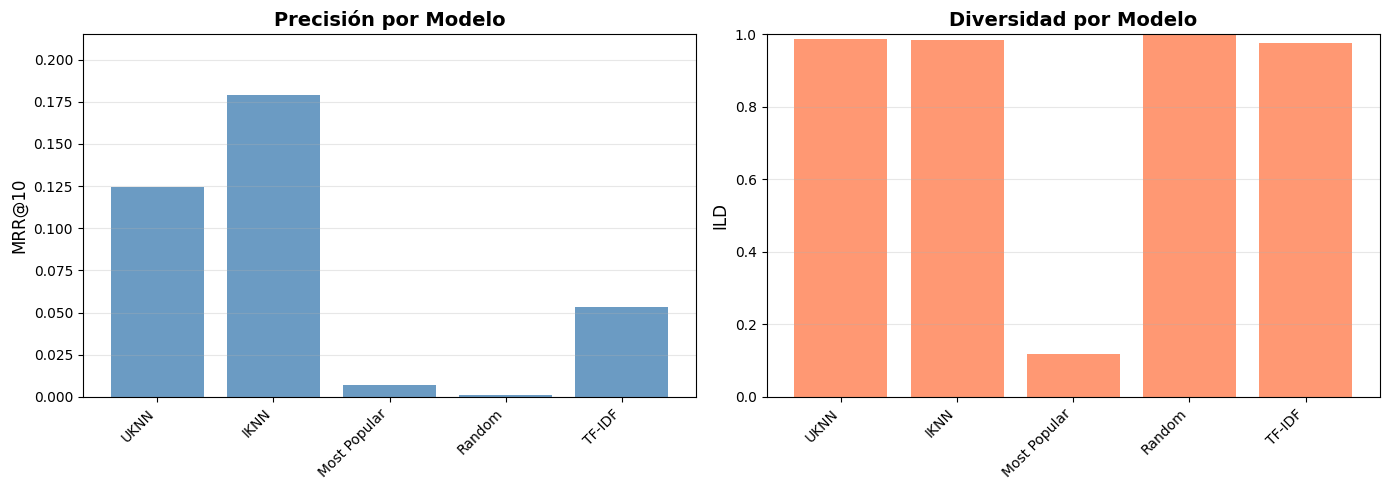

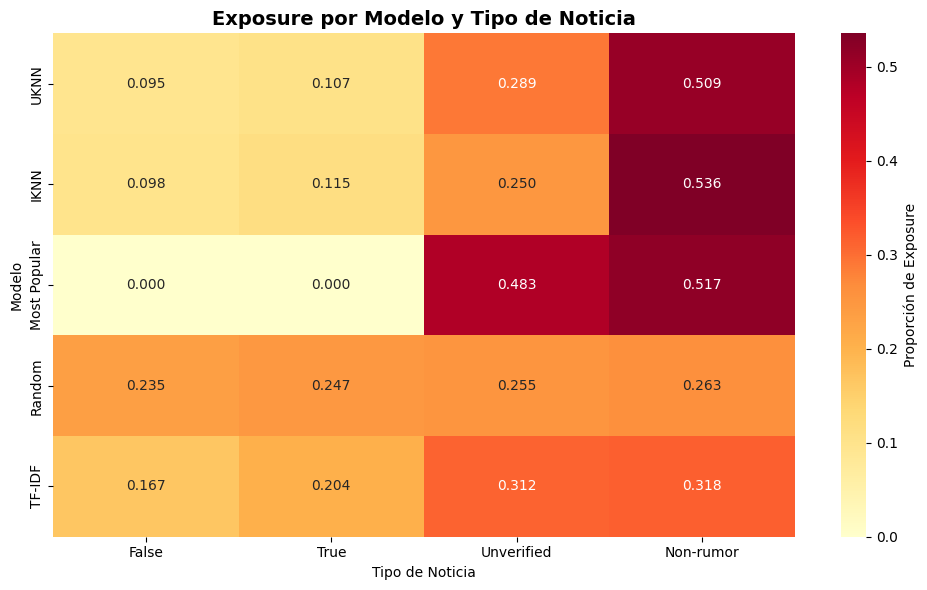

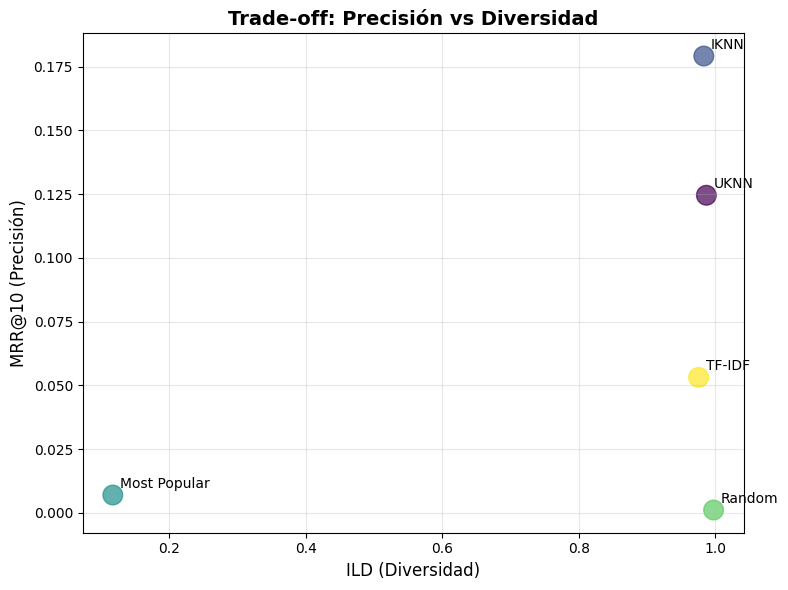

In [27]:
models_list = list(models.keys())
mrr_values = [results[i]["MRR@10"] for i in range(len(results))]
ild_values = [results[i]["ILD"] for i in range(len(results))]

# gráfico 1 mrr e ild por modelo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(models_list, mrr_values, color='steelblue', alpha=0.8)
ax1.set_ylabel('MRR@10', fontsize=12)
ax1.set_title('Precisión por Modelo', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(mrr_values) * 1.2)
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax2.bar(models_list, ild_values, color='coral', alpha=0.8)
ax2.set_ylabel('ILD', fontsize=12)
ax2.set_title('Diversidad por Modelo', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# gráfico 2 heatmap de exposure
exposure_data = []
for name, model_func in models.items():
    recs_all = [model_func(user, top_k=10) for user in test_users]
    exp = exposure(recs_all)
    exposure_data.append([exp['false'], exp['true'], exp['unverified'], exp['non-rumor']])

plt.figure(figsize=(10, 6))
sns.heatmap(exposure_data,
            annot=True,
            fmt='.3f',
            xticklabels=['False', 'True', 'Unverified', 'Non-rumor'],
            yticklabels=models_list,
            cmap='YlOrRd',
            cbar_kws={'label': 'Proporción de Exposure'})
plt.title('Exposure por Modelo y Tipo de Noticia', fontsize=14, fontweight='bold')
plt.ylabel('Modelo')
plt.xlabel('Tipo de Noticia')
plt.tight_layout()
plt.show()

# gráfico 3 mrr vs ild
plt.figure(figsize=(8, 6))
plt.scatter(ild_values, mrr_values, s=200, alpha=0.7, c=range(len(models_list)), cmap='viridis')

for i, model in enumerate(models_list):
    plt.annotate(model, (ild_values[i], mrr_values[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.xlabel('ILD (Diversidad)', fontsize=12)
plt.ylabel('MRR@10 (Precisión)', fontsize=12)
plt.title('Trade-off: Precisión vs Diversidad', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()